# <h1 style="text-align: center;"> Daily Task Scheduling using Genetic Algorithms<h1>

<div dir="rtl"> 

- **وصف المسألة:**

سيكون لدينا قائمة من المهام اليومية كل مهمة لديها مدة زمنية وأولوية.

- **الهدف:**

جدولة المهام بحيث يحقق الجدول ما يلي:
مراعاة الأولوية والمهام المتتابعة

- **القيود:**

  - المجموع الكلي لمدة المهام لا يمكن أن يتجاوز يوم كامل.
  - يجب عدم التداخل بين المهام.
  - قيود تتابع بين المهام يعني مهام يجب أن تأتي قبل الأخرى.
<div>

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import gradio as gr
import os
import tempfile
import json
import ast
import time
from pprint import pprint

<div dir="rtl">فيما يلي مثال عن مجموعة مهام نريد جدولتها حيث أضفنا لكل مهمة مدتها بالساعات وأولويتها والنافذة الزمنية لها إن وجدت.<div>

In [2]:
tasks = [
    {"id": 1, "name": "cook", "duration": 2, "priority": 1},  
    {"id": 2, "name": "study", "duration": 1, "priority": 3},  
    {"id": 3, "name": "play", "duration": 3, "priority": 1},  
    {"id": 4, "name": "work", "duration": 2, "priority": 2},  
    {"id": 5, "name": "walk", "duration": 1, "priority": 2},  
    {"id": 6, "name": "meeting", "duration": 3, "priority": 3},
]

# قائمة التبعيات (مثال: work يجب أن تسبق meeting)
dependencies = [(4, 6)]



##  Chromosome Representation

<div dir="rtl">استخدمنا ترميز permutation وذلك لانه الأنسب لمسألتنا حيث يكون كل كروموسوم هو تسلسل من اندكسات المهام (ارقام) ويمثل الكروموسوم ترتيب المهام 

مثال:

[1, 2, 4, 6, 3, 5]

يعني:

[walk, play, meeting, work, cook, study]

وهذا الترميز هو الانسب لمسألتنا وهو شائع الاستخدام في مسائل الـ job Schedualing
<div>

In [3]:
#انشاء مجموعة الحلول الاولية العشوائية بوضع اسماء المهام في ليست ثم ترتيبها عشوائياً باستخدام Shuffle
def create_chromosome(num_tasks):
    chromosome = list(range(1, num_tasks + 1))
    random.shuffle(chromosome)
    return chromosome

In [4]:
# مثال على إنشاء وطباعة كروموسوم

def print_chromosome(chromosome, tasks):
    print("الكروموسوم:\n", chromosome)
    print("تفاصيل المهام في التسلسل:")
    for gene in chromosome:
        task = next(task for task in tasks if task["id"] == gene)
        print(f"المهمة {task['name']} (ID: {task['id']}): مدة {task['duration']} ساعة, الأولوية: {task['priority']}")

num_tasks = len(tasks)
chromosome = create_chromosome(num_tasks)
print_chromosome(chromosome, tasks)

الكروموسوم:
 [5, 6, 4, 1, 3, 2]
تفاصيل المهام في التسلسل:
المهمة walk (ID: 5): مدة 1 ساعة, الأولوية: 2
المهمة meeting (ID: 6): مدة 3 ساعة, الأولوية: 3
المهمة work (ID: 4): مدة 2 ساعة, الأولوية: 2
المهمة cook (ID: 1): مدة 2 ساعة, الأولوية: 1
المهمة play (ID: 3): مدة 3 ساعة, الأولوية: 1
المهمة study (ID: 2): مدة 1 ساعة, الأولوية: 3


In [5]:
# فك تشفير الكروموسوم فقط لفهم معناه وكيف سيكون تمثيله وللاستفادة منه في صنع الـ fitness func

def chromosome_to_schedule(chromosome, tasks, start_time=8):
    schedule = []
    current_time = start_time
    for gene in chromosome:
        task = next(task for task in tasks if task["id"] == gene)
        start = current_time
        end = current_time + task["duration"]
        schedule.append({
            "name": task["name"],
            "id": task["id"],
            "start_time": start,
            "end_time": end,
            "duration": task["duration"],
            "priority": task["priority"]
        })
        current_time = end
    return schedule
        

#مثال كيف سيكون الجدول الزمني للكروموسوم السابق
#[1, 3, 2, 6, 4, 5]
chromosome_to_schedule(chromosome,tasks, start_time=8)


[{'name': 'walk',
  'id': 5,
  'start_time': 8,
  'end_time': 9,
  'duration': 1,
  'priority': 2},
 {'name': 'meeting',
  'id': 6,
  'start_time': 9,
  'end_time': 12,
  'duration': 3,
  'priority': 3},
 {'name': 'work',
  'id': 4,
  'start_time': 12,
  'end_time': 14,
  'duration': 2,
  'priority': 2},
 {'name': 'cook',
  'id': 1,
  'start_time': 14,
  'end_time': 16,
  'duration': 2,
  'priority': 1},
 {'name': 'play',
  'id': 3,
  'start_time': 16,
  'end_time': 19,
  'duration': 3,
  'priority': 1},
 {'name': 'study',
  'id': 2,
  'start_time': 19,
  'end_time': 20,
  'duration': 1,
  'priority': 3}]

## Selection

<div dir="rtl">استخدمنا طريقة Tournament لانها الاقل تعقيداً و توازن بين الكفاءة (fitness)  والتنوع الجيني لانها تعتمد الاختيار العشوائي أولاً

تعتمد الطريقة على اختيار ابوين ثم اختيار عشوائي لمجموعة من الافراد حسب الـ tournament_size ومن هذه المجموعة العشوائية نختار الأفضل حسب الـ fitness<div>

In [6]:
def tournament_selection(population, fitness_values, tournament_size=3):
    selected = []
    for _ in range(2):
        candidates = np.random.choice(len(population), tournament_size, replace=False)
        winner_idx = candidates[np.argmin([fitness_values[i] for i in candidates])]
        selected.append(population[winner_idx])
    return selected

## Crossover

<div dir="rtl">استخدمنا Order Crossover لانه يحافظ على ترتيب المهام وهو ما نحتاجه لأن البيانات لدينا تمثل تسلسلاً وتفيد هذه الطريقة أيضا بتجنب انتاج  مهام مكررة أو مفقودة

تفاصيل الطريقة:
  - اختيار نقطتي قطع عشوائيتين في الكروموسوم
  - نسخ الأجزاء بين النقطتين من أحد الأبوين إلى الابن
  - ملء الفراغات المتبقية من الأب الآخر مع الحفاظ على الترتيب 
<div>

In [7]:
def order_crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(np.random.choice(size, 2, replace=False))
    
    child1 = [-1] * size
    child2 = [-1] * size
    
    # نسخ الجزء المحدد (بين نقطتي القطع) من الأباء إلى الأبناء
    child1[start:end+1] = parent1[start:end+1]
    child2[start:end+1] = parent2[start:end+1]
    
    # ملء الفراغات من الأب الثاني مع الحفاظ على الترتيب
    pointer = (end + 1) % size
    for p in [parent2, parent1]:
        for i in range(size):
            current_gene = p[(end + 1 + i) % size]
            if current_gene not in child1:
                child1[pointer] = current_gene
                pointer = (pointer + 1) % size
                
        pointer = (end + 1) % size
        for i in range(size):
            current_gene = parent1[(end + 1 + i) % size]
            if current_gene not in child2:
                child2[pointer] = current_gene
                pointer = (pointer + 1) % size
                
    return child1, child2




## Mutation

<div dir="rtl"> تم اختيار طريقة Swap Mutation التي تعمل على تبديل موقعي مهمتين عشوائيا وهذا يفيد في الحفاظ على وجود جميع المهام على عكس الطرق الاخرى التي تعتمد على قلب قيمة الجين او استبداله بقيمة جديدة عشوائية<div>

In [8]:
def swap_mutation(chromosome, mutation_rate=0.1):
    if np.random.rand() < mutation_rate:
        # اختيار موقعين عشوائيين للتبديل
        idx1, idx2 = np.random.choice(len(chromosome), 2, replace=False)
        chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
    return chromosome

## Fitness Function

<div dir="rtl">

- الصيغة:

weighted_completion_time + penalty

وهي دالة Minimization تعتمد على جزئين:

- weightd completion time:
يتم حسابه بناء على وقت إكمال كل مهمة مضروب بوزن يعتمد على أولويتها والهدف هو تقليل هذه المجموع لضمان تنفيذ المهام ذات الاولوية العالية في وقت مبكر.

- penalty of dependency violations:
تعبر عن عقوبة انتهاك التبعيات حيث تضاف عقوبة كبيرة 1000 لكل انتهاك<div>

In [9]:
def fitness_function(chromosome, tasks, dependencies=None):
    schedule = chromosome_to_schedule(chromosome, tasks)
    weighted_completion_time = 0
    penalty = 0

    for entry in schedule:
        weight = entry["priority"]  
        completion_time = entry["end_time"]
        weighted_completion_time += weight * completion_time

    if dependencies:
        for dep in dependencies:
            task_before, task_after = dep
            idx_before = chromosome.index(task_before)
            idx_after = chromosome.index(task_after)
            if idx_before > idx_after:
                penalty += 1000

    return weighted_completion_time + penalty

In [10]:
# مثال لاختبار الدالة
test_chromosomes = [
    [2, 4, 6, 5, 1, 3], #افضل لانه يحافظ على التبعية المهمة 4 قبل 6
    [4, 6, 3, 1, 5, 2], # يحافظ على التبعية لكن لا ينفذ المهام حسب الاولوية الاعلى اولا
    [2, 6, 4, 5, 1, 3], # لا يحاظ على التبعية لذلك هو اسوأهم
     
]
for i, chrom in enumerate(test_chromosomes):
    fitness = fitness_function(chrom,tasks,dependencies)
    print(f"fitness: {fitness}")

fitness: 158
fitness: 191
fitness: 1158


## Evolutionary Loop

In [10]:
POPULATION_SIZE = 50
GENERATIONS = 100
TOURNAMENT_SIZE = 5
mutation_rate=0.1

#التحقق من ادخال المهام والاعتمادات حيث سنعتمد عليه عند اخذ دخل من المستخدم
def validate_tasks(tasks_list):
    try:
        validated_tasks = []
        task_ids = set()
        
        for task in tasks_list:
            if not all(key in task for key in ['id', 'name', 'duration', 'priority']):
                return "خطأ: المهمة لا تحتوي على جميع الحقول المطلوبة (id, name, duration, priority)"
            
            id_ = int(task["id"])
            if id_ in task_ids:
                return f"خطأ: معرف المهمة {id_} مكرر"
            
            task_ids.add(id_)
            validated_tasks.append({
                "id": id_,
                "name": str(task["name"]).strip(),
                "duration": float(task["duration"]),
                "priority": int(task["priority"])
            })
        
        return validated_tasks
    except Exception as e:
        return f"خطأ في تحليل المهام: {str(e)}"

def validate_dependencies(dependencies_list, tasks):
    try:
        validated_deps = []
        task_ids = {task["id"] for task in tasks}
        
        for dep in dependencies_list:
            if len(dep) != 2:
                return "خطأ: كل تبعية يجب أن تحتوي على عنصرين فقط (before, after)"
            
            before = int(dep[0])
            after = int(dep[1])
            
            if before not in task_ids or after not in task_ids:
                return f"خطأ: معرف المهمة {before} أو {after} غير موجود في المهام"
            
            validated_deps.append((before, after))
        
        return validated_deps
    except Exception as e:
        return f"خطأ في تحليل التبعيات: {str(e)}"


In [17]:
def genetic_algorithm(tasks, dependencies, mutation_rate=0.1, population_size=50, generations=100):
    num_tasks = len(tasks)
    population = [create_chromosome(num_tasks) for _ in range(population_size)]
    best_fitness_history = []
    best_chromosome = None
    best_fitness = float('inf')

    for generation in range(generations):
        fitness_scores = [fitness_function(chrom, tasks, dependencies) for chrom in population]
        
        current_best_fitness = min(fitness_scores)
        current_best_idx = fitness_scores.index(current_best_fitness)
        
        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_chromosome = population[current_best_idx].copy()
        
        best_fitness_history.append(best_fitness)

        new_population = [best_chromosome.copy()]
        
        while len(new_population) < population_size:
            parents = tournament_selection(population, fitness_scores)
            
            child1, child2 = order_crossover(parents[0], parents[1])
            
            child1 = swap_mutation(child1, mutation_rate)
            child2 = swap_mutation(child2, mutation_rate)
            
            new_population.extend([child1, child2])
        
        # التأكد من أن حجم السكان صحيح (قد يكون زائداً بواحد إذا كان population_size فردياً)
        population = new_population[:population_size]

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, generations + 1), best_fitness_history)
    plt.xlabel("Generation")
    plt.ylabel("best fitness value")
    plt.title("fitness developing over generations")
    plt.grid(True)
    
    temp_file = os.path.join(tempfile.gettempdir(), "fitness_plot.png")
    plt.savefig(temp_file)
    plt.close()
    
    schedule=chromosome_to_schedule(best_chromosome,tasks, start_time=8)
    fitness = fitness_function(best_chromosome, tasks, dependencies)
    return best_chromosome,schedule, fitness,temp_file,best_fitness_history

In [18]:
def run_genetic_algorithm(tasks_list, dependencies_list, mutation_rate, population_size, generations):
    tasks = validate_tasks(tasks_list)
    if isinstance(tasks, str): 
        return tasks, None
    
    dependencies = validate_dependencies(dependencies_list, tasks) if dependencies_list else []
    if isinstance(dependencies, str):  
        return dependencies, None
    
    best_chromosome,schedule, fitness,temp_file,best_fitness_history = genetic_algorithm(tasks, dependencies, mutation_rate, population_size, generations)
    return best_chromosome,schedule, fitness,temp_file,best_fitness_history

In [19]:
#مثال لاستخدام الدالة:
best_chromosome,schedule, fitness, plot_path, best_fitness_history = run_genetic_algorithm(tasks, dependencies, 0.1, 30, 50)

In [20]:
def result(best_chromosome,schedule, fitness):
    output = f"أفضل كروموسوم\n: {best_chromosome}\n\n"
    output += "الجدول الزمني:\n"
    for entry in schedule:
        output += (f"المهمة {entry['name']} (ID: {entry['id']}): "
                   f"من {entry['start_time']}:00 إلى {entry['end_time']}:00, "
                   f"مدة {entry['duration']} ساعة, الأولوية: {entry['priority']}\n")
    output += f"\nقيمة التقييم (Weighted Completion Time + Penalty): {fitness:.2f}"
    return output

In [21]:
output=result(best_chromosome,schedule, fitness)
print(output)

أفضل كروموسوم
: [2, 5, 4, 6, 1, 3]

الجدول الزمني:
المهمة study (ID: 2): من 8:00 إلى 9.0:00, مدة 1.0 ساعة, الأولوية: 3
المهمة walk (ID: 5): من 9.0:00 إلى 10.0:00, مدة 1.0 ساعة, الأولوية: 2
المهمة work (ID: 4): من 10.0:00 إلى 12.0:00, مدة 2.0 ساعة, الأولوية: 2
المهمة meeting (ID: 6): من 12.0:00 إلى 15.0:00, مدة 3.0 ساعة, الأولوية: 3
المهمة cook (ID: 1): من 15.0:00 إلى 17.0:00, مدة 2.0 ساعة, الأولوية: 1
المهمة play (ID: 3): من 17.0:00 إلى 20.0:00, مدة 3.0 ساعة, الأولوية: 1

قيمة التقييم (Weighted Completion Time + Penalty): 153.00


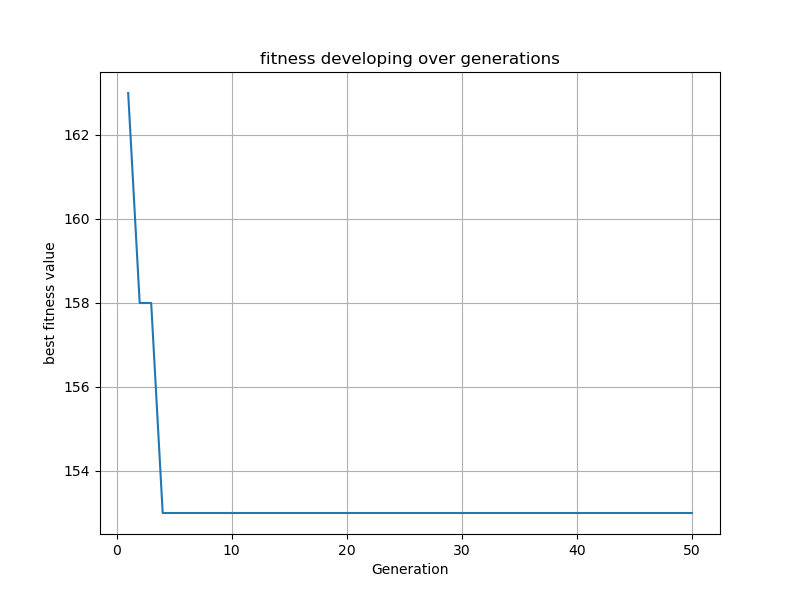

In [20]:
from IPython.display import Image

# عرض المخطط
Image(filename=plot_path)

## Gradio UI

In [ ]:
def validate_and_parse_inputs(tasks_str, deps_str):
    try:
        tasks = json.loads(tasks_str)
        for task in tasks:
            if not all(key in task for key in ['id', 'name', 'duration', 'priority']):
                return None, "خطأ: المهمة لا تحتوي على جميع الحقول المطلوبة (id, name, duration, priority)"
            task['id'] = int(task['id'])
            task['duration'] = float(task['duration'])
            task['priority'] = int(task['priority'])
        
        dependencies = ast.literal_eval(deps_str)
        if not isinstance(dependencies, list):
            dependencies = []
        
        return tasks, dependencies
    except json.JSONDecodeError:
        return None, "خطأ في صيغة JSON للمهام"
    except (ValueError, SyntaxError):
        return None, "خطأ في صيغة التبعيات"

def run_genetic_algorithm_wrapper(tasks_str, deps_str, mutation_rate, pop_size, gens):
    tasks, dependencies = validate_and_parse_inputs(tasks_str, deps_str)
    if tasks is None:
        return dependencies, None, None, None  # إرجاع قيم None للمخرجات الأخرى عند الخطأ
    
    best_chromosome, schedule, fitness, temp_file = run_genetic_algorithm(tasks, dependencies, mutation_rate, pop_size, gens)
    
    # تحويل المخرجات إلى تنسيق مناسب للعرض
    chrom_str = str(best_chromosome)
    schedule_str = "\n".join([f"المهمة {item['id']}: {item['name']} - من {item['start_time']} إلى {item['end_time']}" 
                             for item in schedule])
    fitness_str = f"{fitness:.2f}"
    
    return chrom_str, schedule_str, fitness_str, temp_file

with gr.Blocks() as interface:
    gr.Markdown("# جدولة المهام باستخدام الخوارزميات الجينية")
    
    with gr.Row():
        with gr.Column():
            gr.Markdown("## المدخلات")
            tasks_input = gr.Textbox(
                label="المهام (كسلسلة JSON)",
                value='''[
                    {"id": 1, "name": "cook", "duration": 2, "priority": 1},
                    {"id": 2, "name": "study", "duration": 1, "priority": 3},
                    {"id": 3, "name": "play", "duration": 3, "priority": 1},
                    {"id": 4, "name": "work", "duration": 2, "priority": 2},
                    {"id": 5, "name": "walk", "duration": 1, "priority": 2},
                    {"id": 6, "name": "meeting", "duration": 3, "priority": 3}
                ]''',
                lines=10
            )
            
            dependencies_input = gr.Textbox(
                label="التبعيات (كقائمة بيثون)",
                value="[(4, 6)]",
                lines=2
            )
            
            mutation_rate = gr.Slider(0.0, 1.0, value=0.1, label="معدل الطفرة", step=0.01)
            population_size = gr.Slider(10, 100, value=50, label="حجم السكان", step=1)
            generations = gr.Slider(10, 500, value=100, label="عدد الأجيال", step=1)
            
            submit_button = gr.Button("تشغيل الخوارزمية")

        with gr.Column():
            gr.Markdown("## المخرجات")
            
            with gr.Accordion("أفضل ترتيب للمهام", open=True):
                chrom_output = gr.Textbox(label="أفضل كروموسوم", interactive=False)
            
            with gr.Accordion("الجدول الزمني", open=True):
                schedule_output = gr.Textbox(label="تفاصيل الجدول", interactive=False, lines=10)
            
            with gr.Accordion("نتيجة التقييم", open=True):
                fitness_output = gr.Textbox(label="قيمة اللياقة", interactive=False)
            
    
    submit_button.click(
        fn=run_genetic_algorithm_wrapper,
        inputs=[tasks_input, dependencies_input, mutation_rate, population_size, generations],
        outputs=[chrom_output, schedule_output, fitness_output]
    )

interface.launch()

##  Testing and Validation

<div dir="rtl">
اختبار أداء الخوارزمية الجينية في حل مشكلة جدولة المهام تحت ظروف مختلفة، وذلك من خلال:

-	إعداد حالات اختبار متنوعة (مجموعة مهام مع تبعيات).
-	تغيير معاملات الخوارزمية (مجموعات مختلفة من الإعدادات).
-	لكل تشغيل، قمنا بحساب: أفضل لياقة و متوسط اللياقة و جيل التقارب ووقت التنفيذ.
<div>

In [22]:
test_cases = [
    {
        "name": "الحالة البسيطة",
        "tasks": [
            {"id": 1, "name": "cook", "duration": 2, "priority": 1},
            {"id": 2, "name": "study", "duration": 1, "priority": 3}
        ],
        "dependencies": []
    },
    {
        "name": "حالة متوسطة",
        "tasks": [
            {"id": 1, "name": "work", "duration": 3, "priority": 2},
            {"id": 2, "name": "exercise", "duration": 2, "priority": 1},
            {"id": 3, "name": "meeting", "duration": 4, "priority": 3}
        ],
        "dependencies": [(1, 3)]
    }
]

param_settings = [
    {"mutation_rate": 0.1, "population_size": 50, "generations": 100},
    {"mutation_rate": 0.2, "population_size": 30, "generations": 150},
    {"mutation_rate": 0.05, "population_size": 100, "generations": 80}
]

def run_single_test(tasks, dependencies, params):
    start_time = time.time()
    
    best_solution, schedule, fitness_history, temp_file, fitness_history = run_genetic_algorithm(
    tasks_list=tasks,  
    dependencies_list=dependencies,
    mutation_rate=params['mutation_rate'],
    population_size=params['population_size'],
    generations=params['generations']
)
    
    exec_time = time.time() - start_time
    
    best_fitness = min(fitness_history)
    avg_fitness = sum(fitness_history)/len(fitness_history)
    
    # حساب وقت التقارب (أول ظهور لأفضل لياقة)
    convergence_gen = next(i for i, v in enumerate(fitness_history) if v == best_fitness)
    
    return {
        "best_fitness": best_fitness,
        "average_fitness": avg_fitness,
        "convergence_generation": convergence_gen,
        "execution_time": exec_time,
        "best_solution": best_solution
    }

def run_all_tests():
    for case in test_cases:
        print(f"\n{'='*50}")
        print(f"الحالة: {case['name']}")
        print(f"المهام:")
        pprint(case['tasks'])
        print(f"الاعتمادات: {case['dependencies']}")
        print(f"{'-'*50}")
        
        for i, params in enumerate(param_settings, 1):
            print(f"\nالمتغيرات {i}:")
            print(f"- mutation rate: {params['mutation_rate']}")
            print(f"- population size: {params['population_size']}")
            print(f"- generations: {params['generations']}")
            
            results = run_single_test(case['tasks'], case['dependencies'], params)
            
            print("\nالنتائج:")
            print(f"Best fitness: {results['best_fitness']:.2f}")
            print(f"Average fitness: {results['average_fitness']:.2f}")
            print(f"Convergence time (generation): {results['convergence_generation']}")
            print(f"Best solution: {results['best_solution']}")
            print(f"Execution time: {results['execution_time']:.2f} seconds")
            print(f"{'-'*30}")


run_all_tests()


الحالة: الحالة البسيطة
المهام:
[{'duration': 2, 'id': 1, 'name': 'cook', 'priority': 1},
 {'duration': 1, 'id': 2, 'name': 'study', 'priority': 3}]
الاعتمادات: []
--------------------------------------------------

المتغيرات 1:
- mutation rate: 0.1
- population size: 50
- generations: 100

النتائج:
Best fitness: 38.00
Average fitness: 38.00
Convergence time (generation): 0
Best solution: [2, 1]
Execution time: 0.49 seconds
------------------------------

المتغيرات 2:
- mutation rate: 0.2
- population size: 30
- generations: 150

النتائج:
Best fitness: 38.00
Average fitness: 38.00
Convergence time (generation): 0
Best solution: [2, 1]
Execution time: 0.49 seconds
------------------------------

المتغيرات 3:
- mutation rate: 0.05
- population size: 100
- generations: 80

النتائج:
Best fitness: 38.00
Average fitness: 38.00
Convergence time (generation): 0
Best solution: [2, 1]
Execution time: 0.89 seconds
------------------------------

الحالة: حالة متوسطة
المهام:
[{'duration': 3, 'id': 